# PDA chap. 14: Analyzing Bitly USA.gov data
*(Lowe Wilsson, March 2021 - prepared for [PyLadies](https://pyladies.com/) study group)*

Data used here are from Wes McKinney's [GitHub repository for Python for Data Analysis](https://github.com/wesm/pydata-book).

In [1]:
import json
import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# cartopy is used further down - see 'mapping geographical locations
# of users' section
import cartopy.crs as ccrs

## Loading data into data frame

In [2]:
# path to data file
bitly_path = 'sample_data_files/bitly_usagov.txt'

In [3]:
# load data by converting line-by-line from JSON to dictionaries,
# creating a list of dictionaries
bitly_dict_ls = [json.loads(txt_line) for txt_line in open(bitly_path)]

In [4]:
# peek at first 2 dictionaries
bitly_dict_ls[0:2]

[{'a': 'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/535.11 (KHTML, like Gecko) Chrome/17.0.963.78 Safari/535.11',
  'c': 'US',
  'nk': 1,
  'tz': 'America/New_York',
  'gr': 'MA',
  'g': 'A6qOVH',
  'h': 'wfLQtf',
  'l': 'orofrog',
  'al': 'en-US,en;q=0.8',
  'hh': '1.usa.gov',
  'r': 'http://www.facebook.com/l/7AQEFzjSi/1.usa.gov/wfLQtf',
  'u': 'http://www.ncbi.nlm.nih.gov/pubmed/22415991',
  't': 1331923247,
  'hc': 1331822918,
  'cy': 'Danvers',
  'll': [42.576698, -70.954903]},
 {'a': 'GoogleMaps/RochesterNY',
  'c': 'US',
  'nk': 0,
  'tz': 'America/Denver',
  'gr': 'UT',
  'g': 'mwszkS',
  'h': 'mwszkS',
  'l': 'bitly',
  'hh': 'j.mp',
  'r': 'http://www.AwareMap.com/',
  'u': 'http://www.monroecounty.gov/etc/911/rss.php',
  't': 1331923249,
  'hc': 1308262393,
  'cy': 'Provo',
  'll': [40.218102, -111.613297]}]

In [5]:
# convert from list of dictionaries to pandas data frame
bitly_df = pd.DataFrame(bitly_dict_ls)

In [6]:
bitly_df.head()

,a,c,nk,tz,gr,g,h,l,al,hh,r,u,t,hc,cy,ll,_heartbeat_,kw
0,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,US,1.0,America/New_York,MA,A6qOVH,wfLQtf,orofrog,"en-US,en;q=0.8",1.usa.gov,http://www.facebook.com/l/7AQEFzjSi/1.usa.gov/...,http://www.ncbi.nlm.nih.gov/pubmed/22415991,1.331923e+09,1.331823e+09,Danvers,"[42.576698, -70.954903]",NaN,NaN
1,GoogleMaps/RochesterNY,US,0.0,America/Denver,UT,mwszkS,mwszkS,bitly,NaN,j.mp,http://www.AwareMap.com/,http://www.monroecounty.gov/etc/911/rss.php,1.331923e+09,1.308262e+09,Provo,"[40.218102, -111.613297]",NaN,NaN
2,Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...,US,1.0,America/New_York,DC,xxr3Qb,xxr3Qb,bitly,en-US,1.usa.gov,http://t.co/03elZC4Q,http://boxer.senate.gov/en/press/releases/0316...,1.331923e+09,1.331920e+09,Washington,"[38.9007, -77.043098]",NaN,NaN
3,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_6_8)...,BR,0.0,America/Sao_Paulo,27,zCaLwp,zUtuOu,alelex88,pt-br,1.usa.gov,direct,http://apod.nasa.gov/apod/ap120312.html,1.331923e+09,1.331923e+09,Braz,"[-23.549999, -46.616699]",NaN,NaN
4,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,US,0.0,America/New_York,MA,9b6kNl,9b6kNl,bitly,"en-US,en;q=0.8",bit.ly,http://www.shrewsbury-ma.gov/selco/,http://www.shrewsbury-ma.gov/egov/gallery/1341...,1.331923e+09,1.273672e+09,Shrewsbury,"[42.286499, -71.714699]",NaN,NaN


## Making sense of and filtering columns

In [7]:
# find what time periods that 't' and 'hc' values are from
start_time = datetime.datetime(year=1970, month=1, day=1)

t_min = bitly_df.t.min()
t_max = bitly_df.t.max()

print('t_min')
print(start_time + datetime.timedelta(seconds=t_min))
print('t_max')
print(start_time + datetime.timedelta(seconds=t_max))

hc_min = bitly_df.hc.min()
hc_max = bitly_df.hc.max()

print('hc_min')
print(start_time + datetime.timedelta(seconds=hc_min))
print('hc_max')
print(start_time + datetime.timedelta(seconds=hc_max))

t_min
2012-03-16 18:40:47
t_max
2012-03-16 19:40:49
hc_min
2009-01-21 12:19:58
hc_max
2012-03-16 19:38:11


The columns in the data frame are as follows:
* **a**: 'agent', browser/device/application used by client
* **c**: country
* **nk**: ? Unknown
* **tz**: timezone
* **gr**: ? Possibly 'geographical region' Seems like these are USA state names like 'VA' in some instances, otherwise it's harder to understand them
* **g**: Seems to be a code into which the full URL was converted
* **h**: Seems to be a code into which the full URL was converted (not clear how it's different from 'g' - sometimes they are the same)
* **l**: ? Unknown, sometimes looks like domain names, other times like user names
* **al**: Seems to be language setting used by the client/browser
* **hh**: Seems to be what 'entrypoint'/endpoint was used for accessing a URL shortening service (e. g. 'bit.ly' or '1.usa.gov')
* **r**: Through what indirect URL was the client referred to the shortened link? E. g. 'http://www.facebook.com/l/7AQEFzjSi/1.usa.gov/wfLQtf' (here, it was probably a Facebook user who had posted/message the shortened URL). Has the value 'direct' when someone used the shortened link directly.
* **u**: Original (ie non-shortened) URL 
* **t**: Time in seconds since 1970-01-01 00:00:00 - most likely time at which shortened link was clicked/used.
* **hc**: Appears to also be time in seconds since 1970-01-01 00:00:00 - most likely time at which shortened link was created. 'hc' always has a lower value than 't' (ie occurred earlier) and seems to span times from 2009-01-21 to 2021-03-16. 't' describes events that all occurred on 2021-03-16.
* **cy**: City.
* **ll**: latitude/longitude
* **\_heartbeat\_**: Seems to not be actual data, rather some periodic internal signal
* **kw**: Unclear what this is, mostly NA, maybe an optional 'keyword'?

In [8]:
# form dictionary of old-to-new column name key-value pairs, including
# only columns that are sensible/worth keeping
keep_columns_dict = {
    'a': 'client_software',
    'c': 'country',
    'tz': 'timezone',
    'gr': 'geo_region',
    'al': 'language_setting',
    'hh': 'service_entrypoint',
    'r': 'referral_source',
    'u': 'destination_url',
    't': 'time_click',
    'hc': 'time_creation',
    'cy': 'city',
    'll': 'latitude_longitude'
}

In [9]:
# extract only relevant columns
bitly_df = bitly_df.filter(keep_columns_dict.keys())

In [10]:
# rename columns
bitly_df = bitly_df.rename(columns=keep_columns_dict)

In [11]:
bitly_df.head()

,client_software,country,timezone,geo_region,language_setting,service_entrypoint,referral_source,destination_url,time_click,time_creation,city,latitude_longitude
0,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,US,America/New_York,MA,"en-US,en;q=0.8",1.usa.gov,http://www.facebook.com/l/7AQEFzjSi/1.usa.gov/...,http://www.ncbi.nlm.nih.gov/pubmed/22415991,1.331923e+09,1.331823e+09,Danvers,"[42.576698, -70.954903]"
1,GoogleMaps/RochesterNY,US,America/Denver,UT,NaN,j.mp,http://www.AwareMap.com/,http://www.monroecounty.gov/etc/911/rss.php,1.331923e+09,1.308262e+09,Provo,"[40.218102, -111.613297]"
2,Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...,US,America/New_York,DC,en-US,1.usa.gov,http://t.co/03elZC4Q,http://boxer.senate.gov/en/press/releases/0316...,1.331923e+09,1.331920e+09,Washington,"[38.9007, -77.043098]"
3,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_6_8)...,BR,America/Sao_Paulo,27,pt-br,1.usa.gov,direct,http://apod.nasa.gov/apod/ap120312.html,1.331923e+09,1.331923e+09,Braz,"[-23.549999, -46.616699]"
4,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,US,America/New_York,MA,"en-US,en;q=0.8",bit.ly,http://www.shrewsbury-ma.gov/selco/,http://www.shrewsbury-ma.gov/egov/gallery/1341...,1.331923e+09,1.273672e+09,Shrewsbury,"[42.286499, -71.714699]"


In [12]:
# split latitude/longitude into separate columns
latitudes = []
longitudes = []
for coord in bitly_df.latitude_longitude:
    if isinstance(coord, list):
        latitudes.append(coord[0])
        longitudes.append(coord[1])
    else:
        latitudes.append(np.nan)
        longitudes.append(np.nan)

bitly_df['latitude'] = latitudes
bitly_df['longitude'] = longitudes
# drop now redundant column
bitly_df.drop('latitude_longitude', axis=1, inplace=True)

In [13]:
# convert times to datetime objects
start_time = datetime.datetime(year=1970, month=1, day=1)

def convert_to_datetime(s1970):
    if np.isnan(s1970):
        return np.nan
    return start_time + datetime.timedelta(seconds=s1970)

bitly_df['time_click'] = bitly_df.time_click.apply(convert_to_datetime)
bitly_df['time_creation'] = bitly_df.time_creation.apply(convert_to_datetime)

In [14]:
bitly_df.head()

,client_software,country,timezone,geo_region,language_setting,service_entrypoint,referral_source,destination_url,time_click,time_creation,city,latitude,longitude
0,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,US,America/New_York,MA,"en-US,en;q=0.8",1.usa.gov,http://www.facebook.com/l/7AQEFzjSi/1.usa.gov/...,http://www.ncbi.nlm.nih.gov/pubmed/22415991,2012-03-16 18:40:47,2012-03-15 14:48:38,Danvers,42.576698,-70.954903
1,GoogleMaps/RochesterNY,US,America/Denver,UT,NaN,j.mp,http://www.AwareMap.com/,http://www.monroecounty.gov/etc/911/rss.php,2012-03-16 18:40:49,2011-06-16 22:13:13,Provo,40.218102,-111.613297
2,Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...,US,America/New_York,DC,en-US,1.usa.gov,http://t.co/03elZC4Q,http://boxer.senate.gov/en/press/releases/0316...,2012-03-16 18:40:50,2012-03-16 17:45:41,Washington,38.900700,-77.043098
3,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_6_8)...,BR,America/Sao_Paulo,27,pt-br,1.usa.gov,direct,http://apod.nasa.gov/apod/ap120312.html,2012-03-16 18:40:49,2012-03-16 18:37:48,Braz,-23.549999,-46.616699
4,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,US,America/New_York,MA,"en-US,en;q=0.8",bit.ly,http://www.shrewsbury-ma.gov/selco/,http://www.shrewsbury-ma.gov/egov/gallery/1341...,2012-03-16 18:40:51,2010-05-12 13:53:31,Shrewsbury,42.286499,-71.714699


## Mapping geographical locations of users

For projecting latitudes/longitudes onto a map, cartopy is used.

[cartopy installation instructions](https://scitools.org.uk/cartopy/docs/latest/installing.html#installing)

[Introduction to using cartopy with matplotlib](https://scitools.org.uk/cartopy/docs/latest/matplotlib/intro.html)

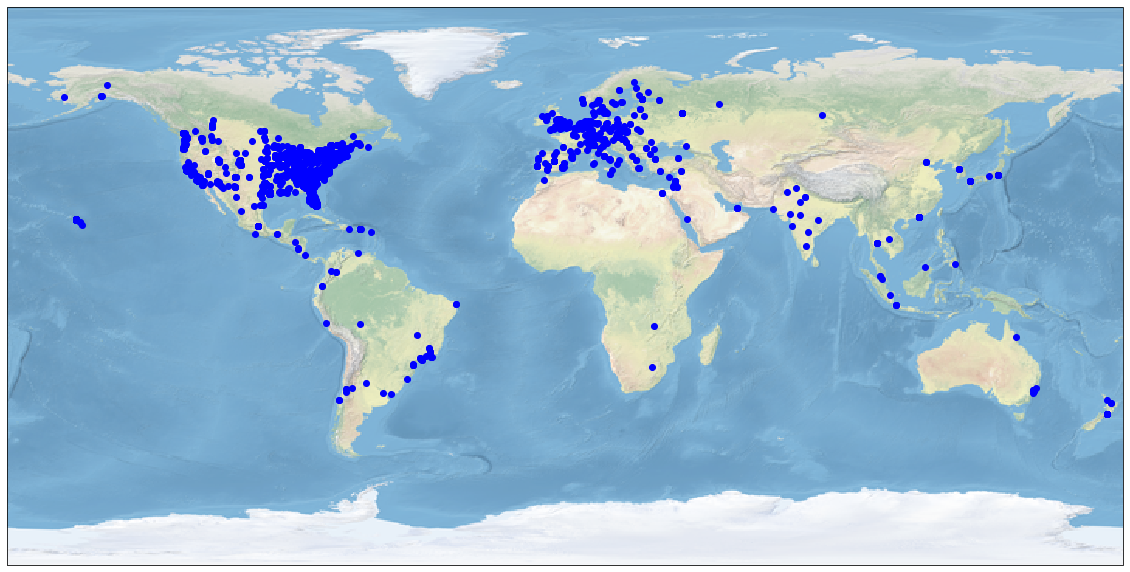

In [15]:
# map all user location data
# set figure size
fig, ax = plt.subplots(figsize=(20, 20))
# generate axis, specifying a projection
# (this is basically just copying code from the cartopy
# introduction)
ax = plt.axes(projection=ccrs.PlateCarree())
# set a 'stock image' of Earth as background
ax.stock_img()
# add points on top of the image of Earth, using
# longitudes (ie x coordinates) and latitudes 
ax.scatter(
    bitly_df.longitude, bitly_df.latitude,
    color='blue', marker='o',
)

plt.show()

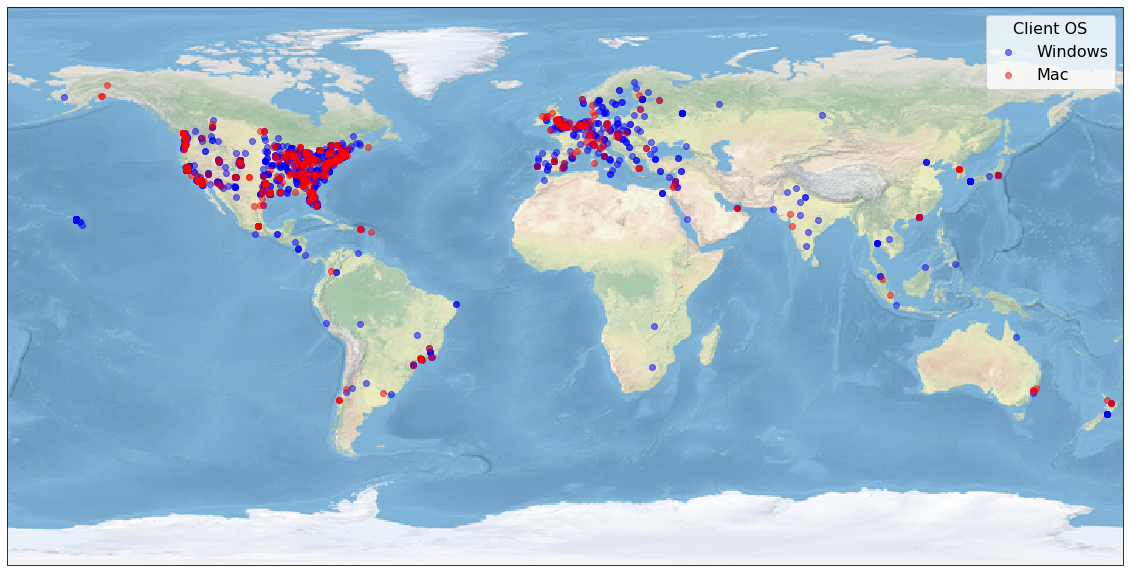

In [16]:
# compare locations of Windows and Mac users
win_df = bitly_df[bitly_df.client_software.str.contains('win', na=False, case=False)]
mac_df = bitly_df[bitly_df.client_software.str.contains('mac', na=False, case=False)]

fig, ax = plt.subplots(figsize=(20, 20))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.stock_img()

# add different-colored points (blue for Windows, red for Mac)
# to the same plot
for color, df, label in zip(['blue', 'red'], [win_df, mac_df], ['Windows', 'Mac']):
    ax.scatter(
        df.longitude, df.latitude,
        color=color, marker='o',
        alpha=0.5,
        label=label
    )

ax.legend(
    title="Client OS",
    title_fontsize=16,
    fontsize=16
)
    
plt.show()

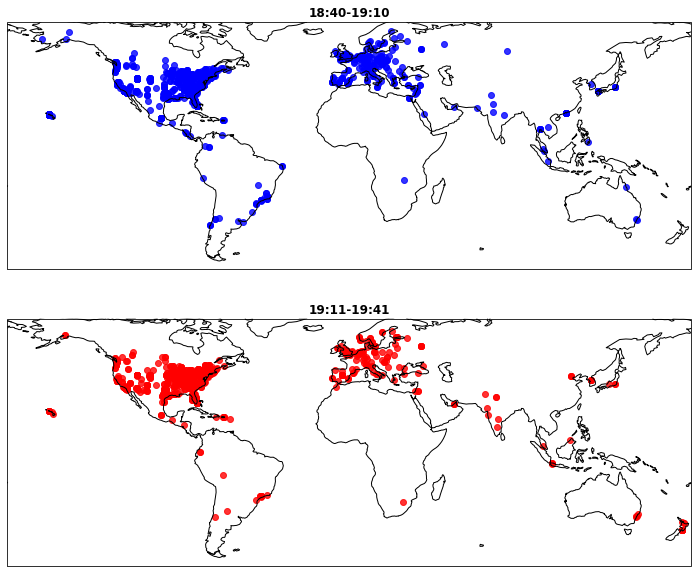

In [17]:
# compare locations of users active between 18:40-19:10 to
# those of users active inbetween 19:11-19:41
time_df = bitly_df.set_index('time_click')
earlier_df = time_df.between_time('18:40', '19:10', include_end=False)
later_df = time_df.between_time('19:10', '19:41')

# form a figure consisting of two axes/subplots,
# using `subplot_kw` to specify that each one should
# be created with `projection=ccrs.PlateCarree()`, 
# like we did above
fig, axes = plt.subplots(
    2, 1,
    figsize=(20, 10), 
    subplot_kw={'projection': ccrs.PlateCarree()}
)

# # plotting 'earlier' users in blue, 'later' users in red
plot_specs = zip(['blue', 'red'], [earlier_df, later_df], axes, ['18:40-19:10', '19:11-19:41'])
for color, df, ax, title in plot_specs:
    ax.coastlines()
    ax.scatter(
        df.longitude, df.latitude,
        color=color, marker='o',
        alpha=0.8
    )
    ax.set_title(title, {'fontWeight': 600})
    ax.set_xlim(-180, 180)
    ax.set_ylim(-60, 70)
plt.show()

## Comparing referral sources 

In [18]:
ref_urls = bitly_df.referral_source

In [19]:
# define function which converts from URL to a string
# which describes the corresponding domain (one of the common ones,
# or 'other')
def to_domain(url):
    if not isinstance(url, str):
        return np.nan
    if 'facebook' in url:
        return 'Facebook'
    if 't.co' in url or 'twitter' in url:
        return 'Twitter'
    if 'google' in url:
        return 'Google'
    if '.gov' in url:
        return '.gov domains'
    if url == 'direct':
        return 'No referral (direct use)'
    return 'Other'

domains = ref_urls.apply(to_domain)

In [20]:
# take a look to see that domains are correctly extracted
pd.DataFrame({'url': ref_urls[:5], 'domain_label': domains[:5]})

,url,domain_label
0,http://www.facebook.com/l/7AQEFzjSi/1.usa.gov/...,Facebook
1,http://www.AwareMap.com/,Other
2,http://t.co/03elZC4Q,Twitter
3,direct,No referral (direct use)
4,http://www.shrewsbury-ma.gov/selco/,.gov domains


In [21]:
domain_counts = domains.value_counts()

[Text(0, 0, '0'),
 Text(0, 0, '500'),
 Text(0, 0, '1000'),
 Text(0, 0, '1500'),
 Text(0, 0, '2000')]

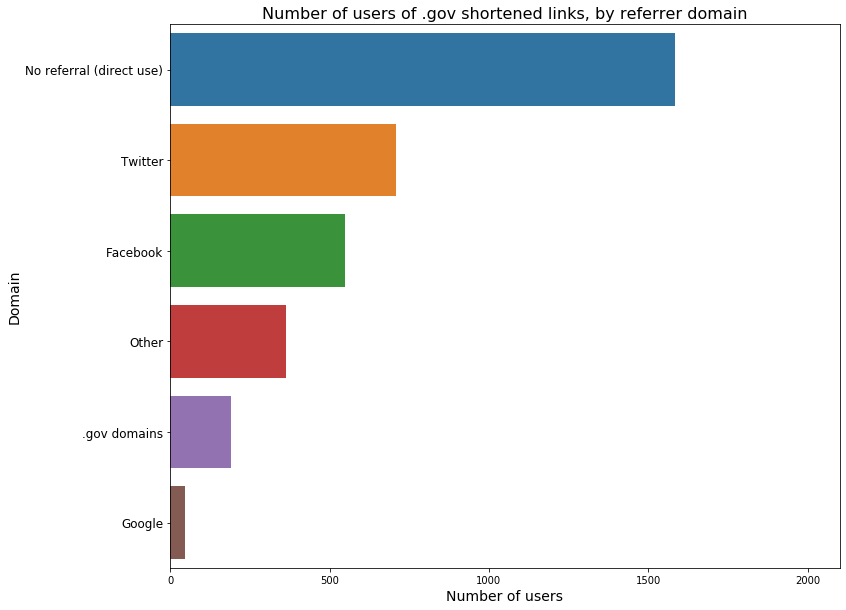

In [22]:
fig, ax = plt.subplots(figsize=(12, 10))
sns.barplot(x=domain_counts, y=domain_counts.index)
ax.set_title(
    'Number of users of .gov shortened links, by referrer domain',
    {
        'fontweight': 500,
        'fontsize': 16
    }
)
ax.set_xlabel(
    'Number of users',
    {
        'fontweight': 530,
        'fontsize': 14
    }
)
ax.set_ylabel(
    'Domain',
    {
        'fontweight': 530,
        'fontsize': 14
    }
)
ax.set_xlim(0, 2100)
ax.set_yticklabels(ax.get_yticklabels(), fontdict={'fontsize': 12})
ax.set_xticks([x for x in range(0, 2001, 500)])
ax.set_xticklabels([x for x in range(0, 2001, 500)])